In [2]:
import pandas as pd
from datetime import date
import numpy as np
import holidays
import calendar
from itertools import groupby
import matplotlib.pyplot as plt
import os, time
import datetime
from datetime import datetime, timedelta

In [5]:
data = pd.read_csv('ha_data.csv', sep=';')

In [6]:
#Так как нет данных про стоимости покупок и кликов, дать точный ответ о продаже тех или иных баннеров нельзя,
#исходя из простого соображения, что достаточно высокая цена за клик делает продажу рекламного места выгодной.
#По этой причине в этой задаче я буду исследовать эффективность баннера по кажому сегменту.

In [7]:
df=data
df.columns=['order_id','page_id','Product','site_version','time','title','user']

In [1]:
#тип события в процентах для каждого сегмента
for element in set(df['Product']):
    d1=len(df[(df['title']=='banner_show')&(df['Product']==element)])/len(df[df['Product']==element])*100
    d2=len(df[(df['title']=='banner_click')&(df['Product']==element)])/len(df[df['Product']==element])*100
    d3=len(df[(df['title']=='order')&(df['Product']==element)])/len(df[df['Product']==element])*100
    counts = [d1,d2,d3]
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.pie(counts,
        colors=['blue','yellow','red'],
        labels=['banner_show','banner_click' ,'order'],
        startangle=90,
        autopct='%1.1f%%',)
    ax.set_title(element)
    
    




NameError: name 'df' is not defined

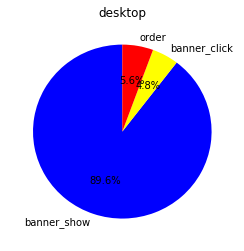

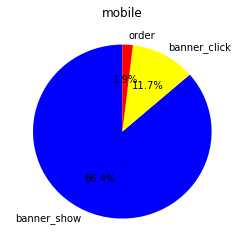

In [71]:
#тип события в процентах для каждого устройства
for element in set(df['site_version']):  
    d1=len(df[(df['title']=='banner_show')&(df['site_version']==element)])/len(df)*100
    d2=len(df[(df['title']=='banner_click')&(df['site_version']==element)])/len(df)*100
    d3=len(df[(df['title']=='order')&(df['site_version']==element)])/len(df)*100
    counts = [d1,d2,d3]
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.pie(counts,
        colors=['blue','yellow','red'],
        labels=['banner_show','banner_click' ,'order'],
        startangle=90,
        autopct='%1.1f%%',)
    ax.set_title(element)
    
    

In [150]:
df=df.sort_values('time')

In [151]:
df.head()

,order_id,page_id,Product,site_version,time,title,user
2989252,NaN,7446868.0,accessories,desktop,2017-01-01 00:00:03,banner_show,user_1365850
2407919,NaN,5639042.0,accessories,mobile,2017-01-01 00:00:05,banner_show,user_1064565
2595058,NaN,7310704.0,clothes,desktop,2017-01-01 00:00:15,banner_show,user_1162467
1764739,NaN,3745903.0,sneakers,mobile,2017-01-01 00:00:25,banner_show,user_742569
3918929,NaN,10200275.0,company,desktop,2017-01-01 00:00:25,banner_show,user_1827807


In [152]:
# Через page id подсчитаем рекламную конверсию, т.е. отношение числа показов к числу кликов в каждом сегменте
pr = pd.DataFrame()
x=list()
y=list()
for element in set(df['Product']):
    a=sum(df[df['Product']==element]['page_id'].value_counts())
    b=len(df[df['Product']==element]['page_id'].value_counts())
    d=(a-b)/b*100
    x.append(element)
    y.append(d)
pr['product'] = pd.Series(x).values
pr['conversion %'] = pd.Series(y).values 

In [153]:
pr.sort_values('conversion %',ascending=False)

,product,conversion %
3,clothes,15.180700
4,sneakers,12.566645
1,sports_nutrition,9.885468
0,accessories,9.455819
2,company,9.164506


In [154]:
#Предлагаю следующее решение.Зафиксируем сегмент. Посмотрим на число уникальных пользователей, посетивших сайт и увидевших 
#баннер, посчитаем сколько из них кликнуло на него и сколько затем купило товар. 
#Таким образом  посчитаем конверсию в продажах
# В расчет будем брать тех людей, у которых время хотя бы последней покупки позже первого клика по баннеру, исходя из той идеи, 
#что предполагаем , что баннер эффективен , если клиент его видит, затем кликает и покупает.
pr1 = pd.DataFrame()
a=list()
b=list()
c=list()
d=list()
for element in set(df['Product']):
    d1=len(df[(df['title']=='banner_show')&(df['Product']==element)]['user'].unique())
    d2=len(df[(df['title']=='banner_click')&(df['Product']==element)]['user'].unique())
    spis=list(df[(df['title']=='banner_click')&(df['Product']==element)]['user'].unique()) # есть баннер и клик
    df1=df[df['user'].isin(spis)]
    spis=list(df1[(df1['title']=='order')&(df1['Product']==element)]['user'].unique()) # есть баннер,клик и покупка
    df1=df1[df1['user'].isin(spis)]
    spis1=spis
    for elem in spis:
        x=list(df1[(df1['user']==elem)&(df1['title']=='banner_click')]['time'])
        y=list(df1[(df1['user']==elem)&(df1['title']=='order')]['time'])
        if (x[0]>y[len(y)-1]):
            spis1.remove(elem)
    df1=df1[df1['user'].isin(spis1)]    
    d3=len(df1[(df1['title']=='order')&(df1['Product']==element)]['user'].unique()) #учтено что время последней покупки позже времени первого клика
    a.append(element)
    b.append(d1)
    c.append(d2/d1*100)
    d.append(d3/d1*100)
pr1['product'] = pd.Series(a).values
pr1['number of users'] = pd.Series(b).values
pr1['click %'] = pd.Series(c).values
pr1['order %'] = pd.Series(d).values


In [155]:
pr1.sort_values('order %',ascending=False)

,product,number of users,click %,order %
3,clothes,1164914,18.036439,0.805896
4,sneakers,1163808,15.019831,0.468118
0,accessories,1155775,11.420735,0.263113
1,sports_nutrition,1173163,11.921106,0.138003
2,company,1256721,11.194450,0.000000


In [156]:
#То же самое только фиксимруем версию сайта
pr2 = pd.DataFrame()
a=list()
b=list()
c=list()
d=list()
e=list()
df1=df[df['site_version']=='desktop']
for element in set(df['Product']):
    d1=len(df1[(df1['title']=='banner_show')&(df1['Product']==element)]['user'].unique())
    d2=len(df1[(df1['title']=='banner_click')&(df1['Product']==element)]['user'].unique())
    spis=list(df1[(df1['title']=='banner_click')&(df['Product']==element)]['user'].unique()) # есть баннер и клик
    df2=df1[df1['user'].isin(spis)]
    spis=list(df2[(df2['title']=='order')&(df2['Product']==element)]['user'].unique()) # есть баннер,клик и покупка
    df2=df2[df2['user'].isin(spis)]
    spis1=spis
    for elem in spis:
        x=list(df2[(df2['user']==elem)&(df2['title']=='banner_click')]['time'])
        y=list(df2[(df2['user']==elem)&(df2['title']=='order')]['time'])
        if (x[0]>y[len(y)-1]):
            spis1.remove(elem)
    df2=df2[df2['user'].isin(spis1)]    
    d3=len(df2[(df2['title']=='order')&(df1['Product']==element)]['user'].unique()) #учтено что время последней покупки позже времени первого клика
    a.append(element)
    b.append(d1)
    c.append(d2/d1*100)
    d.append(d3/d1*100)
    e.append('desktop')
pr2['product'] = pd.Series(a).values
pr2['number of users'] = pd.Series(b).values
pr2['click %'] = pd.Series(c).values
pr2['order %'] = pd.Series(d).values
pr2['site_version'] =  pd.Series(e).values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [157]:
pr2.sort_values('order %',ascending=False)

,product,number of users,click %,order %,site_version
3,clothes,373067,8.687448,1.008666,desktop
4,sneakers,367953,5.783891,0.403584,desktop
0,accessories,366314,5.031203,0.262343,desktop
1,sports_nutrition,372552,3.707670,0.112468,desktop
2,company,419769,6.721078,0.000000,desktop


In [158]:
#То же самое только фиксимруем версию сайта
pr3 = pd.DataFrame()
a=list()
b=list()
c=list()
d=list()
e=list()
df1=df[df['site_version']=='mobile']
for element in set(df['Product']):
    d1=len(df1[(df1['title']=='banner_show')&(df1['Product']==element)]['user'].unique())
    d2=len(df1[(df1['title']=='banner_click')&(df1['Product']==element)]['user'].unique())
    spis=list(df1[(df1['title']=='banner_click')&(df['Product']==element)]['user'].unique()) # есть баннер и клик
    df2=df1[df1['user'].isin(spis)]
    spis=list(df2[(df2['title']=='order')&(df2['Product']==element)]['user'].unique()) # есть баннер,клик и покупка
    df2=df2[df2['user'].isin(spis)]
    spis1=spis
    for elem in spis:
        x=list(df2[(df2['user']==elem)&(df2['title']=='banner_click')]['time'])
        y=list(df2[(df2['user']==elem)&(df2['title']=='order')]['time'])
        if (x[0]>y[len(y)-1]):
            spis1.remove(elem)
    df2=df2[df2['user'].isin(spis1)]    
    d3=len(df2[(df2['title']=='order')&(df1['Product']==element)]['user'].unique()) #учтено что время последней покупки позже времени первого клика
    a.append(element)
    b.append(d1)
    c.append(d2/d1*100)
    d.append(d3/d1*100)
    e.append('mobile')
pr3['product'] = pd.Series(a).values
pr3['number of users'] = pd.Series(b).values
pr3['click %'] = pd.Series(c).values
pr3['order %'] = pd.Series(d).values
pr3['site_version'] =  pd.Series(e).values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [159]:
pr3.sort_values('order %',ascending=False)

,product,number of users,click %,order %,site_version
3,clothes,794006,22.386481,0.704907,mobile
4,sneakers,797950,19.241431,0.493264,mobile
0,accessories,791575,14.348988,0.259230,mobile
1,sports_nutrition,802766,15.702957,0.149732,mobile
2,company,839538,13.400108,0.000000,mobile


In [160]:
#Как видим по таблицам конверсия по продажам лучше всего в сегменте clothes, а хуже всего в sport nutrition.
#Дальнейшее решение сильно зависит от стоимости покупок в сегменте и стоимости клика. Если бы это было известно, то
#можно было бы сравнить стоимость всех кликов и стоимость всех покупок ,и в зависимости от того какая величина больше в среднем,
#принять решение.